In [1]:

"""
@author: Brendan
I want to explore the relationship between variables, including age, gender, class of ticket (i.e. first, second), and how they relate to the survival rate.
"""

import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


In [2]:

sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)


In [17]:
"""  IMPORTING the DATA  """

# Read CSV train data file into DataFrame
train_df = pd.read_csv("train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("test.csv")


In [19]:

# preview train data
train_df.head()
print('The number of samples in the train data is {}.'.format(train_df.shape[0]))
# preview test data
test_df.head()
print('The number of samples in the test data is {}.'.format(test_df.shape[0]))


The number of samples in the train data is 891.
The number of samples in the test data is 418.


In [21]:

"""Checking if there are missing values"""

# Checking if there are missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see here that 177 passengers are missing an "Age" value, 
687 are missing a "Cabin" value,
2 are missing a "Emabarked" value.

I will investigate filling in missing values for "Age", "Cabin", and "Embarked".  All 3 will be investigated before missing values are filled in.

In [22]:

"""Age as a missing Value"""
# Next is the percent of missing "Age" value
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))


Percent of missing "Age" records is 19.87%


Next we will take a look at the mean and median as well as a histogram of the "Age" variable. 

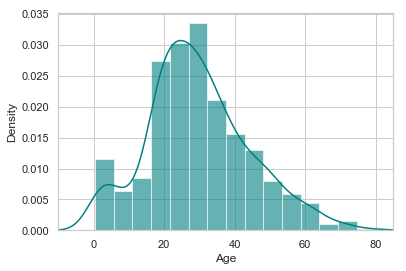

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [24]:
"""Histogram of Age"""
histo = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
histo.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

# Mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))

# Median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))


We can see here that "Age" is right skewed. Meaning there is a larger number of 30 and below passengers than 30+ passengers.
30 year olds looks to make up the largest number of passengers.
Since I want to try to fill in the missing values in "Age" using the mean value can be good choice.
The mean of "Age" is 29.70 years old.
Now as the most prevelent age is 30 29.70 could be a good value to use to fill in the missing "Age" values. However, as "Age" is right skewed the mean may give us a more biased result 

So, we will take another approach and check the median value.
The median of "Age" is 28.00 years old
The median is smaller than the mean and "Age" is right skewed, we will be using the median when filling in the missing "Age" values.  


In [25]:
"""Missing Cabin Values"""

# Next we will investigate the percent of missing "Cabin" values
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))


Percent of missing "Cabin" records is 77.10%


Since we are missing 77% of these values inputting a value for prediction is a bad idea, so will ignore this variable in our model.

In [26]:
"""EMBARKED MISSING VALUES"""

# Lets consider the percent of missing "Embarked" values
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))


Percent of missing "Embarked" records is 0.22%


There are only 2 port missing values. In this case I would suggest using the port from which most passengers embarked from to fill in the missing values.
Now lets find out how many passengers embarked from each of the three ports. C = Cherbourg, Q = Queenstown, S = Southampton.

Passengers grouped by port of embarkment (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


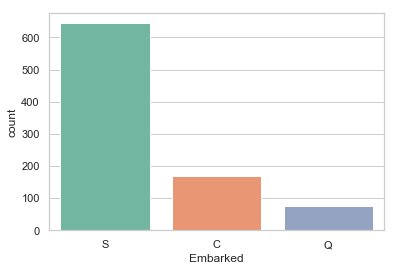

The most common boarding port of embarkment is S.


In [27]:
print('Passengers grouped by port of embarkment (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())

# Lets create a histogram to visually represent the number of passengers which embarked from each port.
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()
print('The most common boarding port of embarkment is %s.' %train_df['Embarked'].value_counts().idxmax())


As we can see from the count plot 'S' or Southampton. Therefore I will be inputing Southampton for the 2 missing values.

Now the final assessment of what we are replacting the missing values with
If "Age" is missing for a given row, I'll input the median age which is "28".
If "Embarked" is missing for a given row, I'll input "S" which is the most common boarding port.
I'll drop "Cabin" as there is a large percent of missing values. 

In [28]:
#inputing the missing values into the training set
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

As we can see all of the missing values have been filled in and the "Cabin" variable has been dropped.

In [29]:
# preview adjusted train data
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Now I will graph the "Age" variable again as a histogram, however, this time I will be comparing the values before the train data set was adjusted to the train data set after it was adjusted.

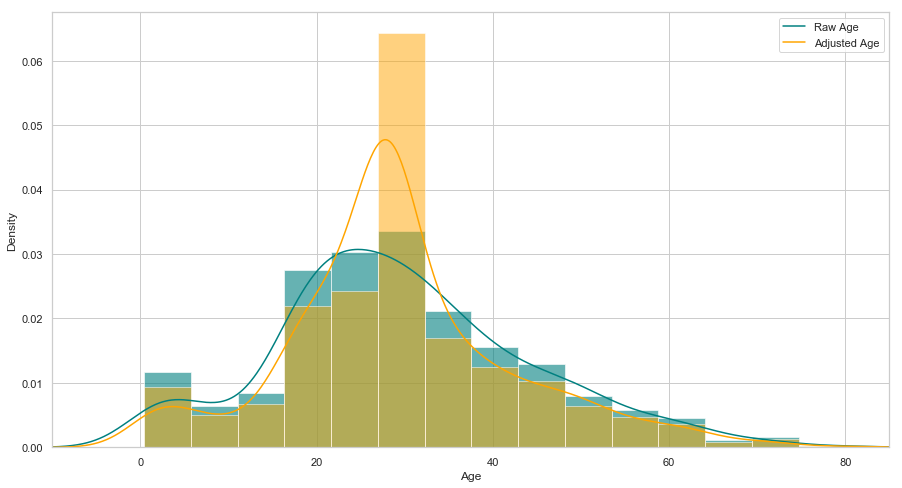

In [30]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()


The adjusted "age" is not skewed right anymore it is much more "normal" as seen by the yellow graph.

"SibSp" and "Parch" are both related to traveling with family, to handle the multicollinearity related to these two variables I will combine these two variables into one categorical predictor, whether or not an individual was traveling alone.

In [31]:
"""Handeling additional variables"""
# Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)


I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked").

In [32]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


Now that the training data set is all ready I will need to do a similar process to the test set.
To speed this up I will provide a quick summary of the steps.
I will input the same value for "Age" I did in the Training data (if missing, "Age" = 28).
"Cabin" column will be removed as I have decided not to include it in my analysis.
There are no missing values in "Embarked" so there is nothing to fill in the test data set.
Since there is 1 missing value in "Fare" in the test set I will use the median, 14.45, to fill that in.
Then I will add the categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked") and "TravelAlone"

In [34]:
test_df.isnull().sum()
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()


,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


Now that the train and test data sets are prepared we can move onto the Analsis portion.
I will start with creating a KDE plot that compares the "Age" of the survivors to that of the non-survivors.

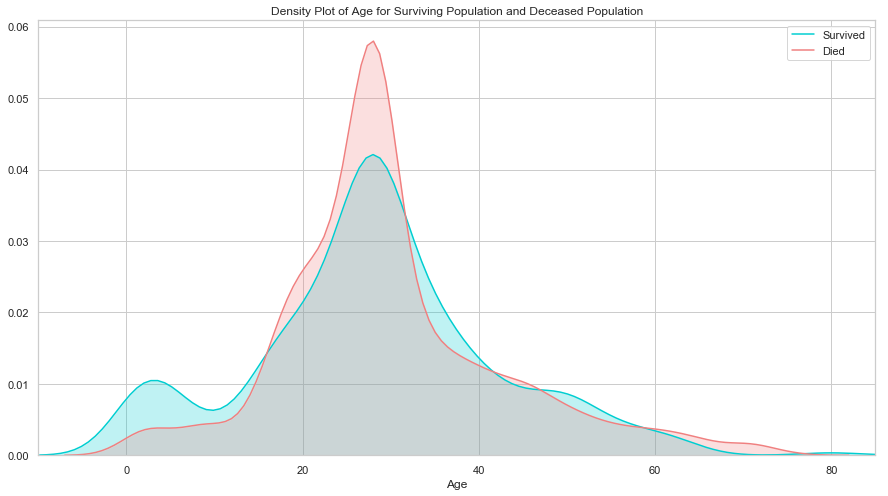

In [36]:

"""DATA ANALYSIS"""
"""Looking into AGE"""
plt.figure(figsize=(15,8))
kde = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
kde.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()


The Age distribution of survivors is very similar to that of who died, the biggest difference is that a greater number of children survived, this shows that passengers prioritized saving children.
However, it should also be noted that the "Age" 28 was used to fill in many of the missing age values, therefore that will have an impact on the number of deaths/survivors.  
Also, the 28 age range had the largest number of members in it so it makes sense that the largest number of survivors and deaths come from this age range.


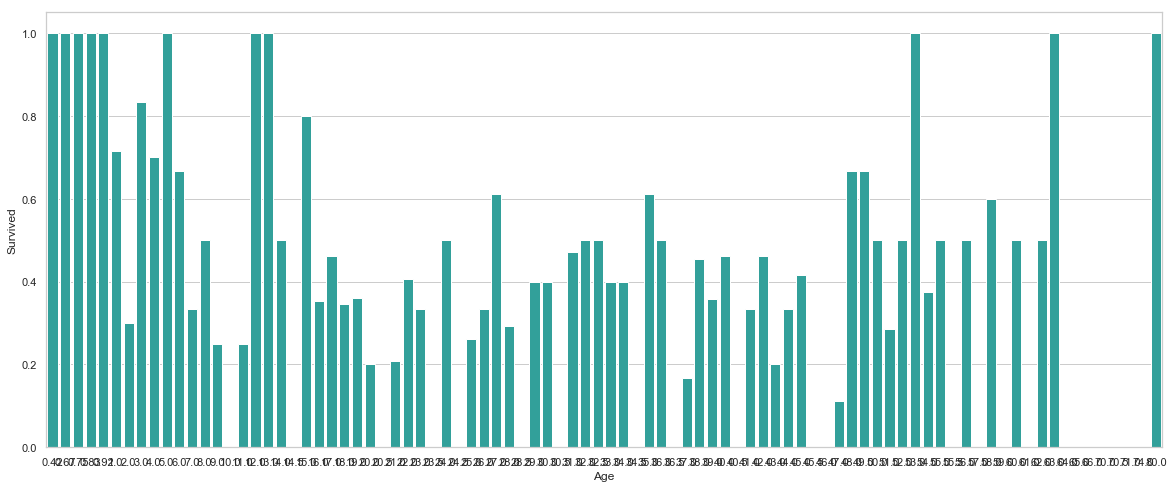

In [42]:

"""Creating a barchart of age of survivors"""
# Now create a bar chart to represent the survivors 

plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
bar = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()


As we can see this bar chart is not super useful as it is hard to read. So I will create another variable called "IsMinor". This should make it a bit easier to read, and there was also a significant number of children that survived.


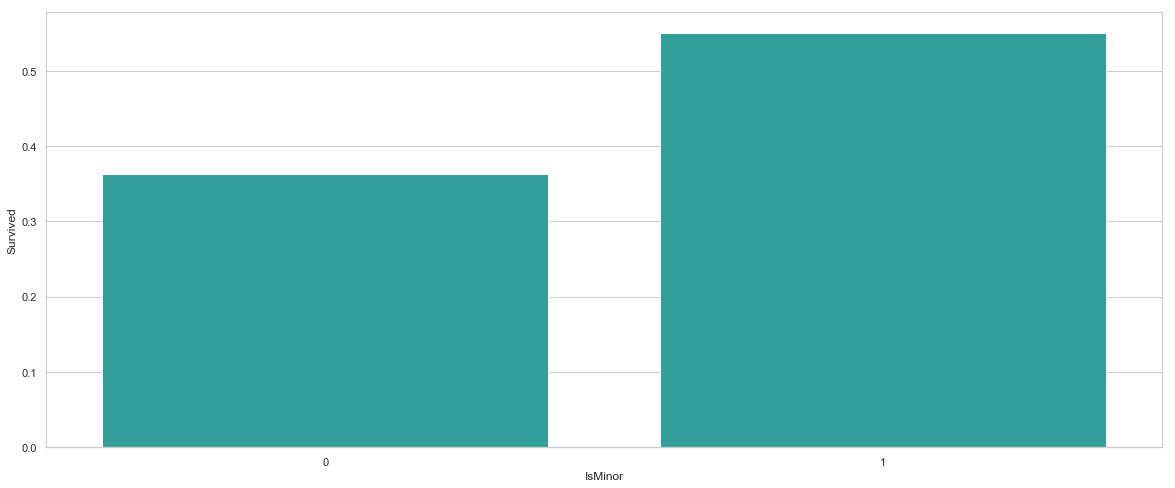

In [44]:

final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

final_test.head()
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["IsMinor", "Survived"]].groupby(['IsMinor'], as_index=False).mean()
bar = sns.barplot(x='IsMinor', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

As we can see a larger percentage of minors survived. Minors are "1" non-minors are "0"
Now moving on to "Fare"

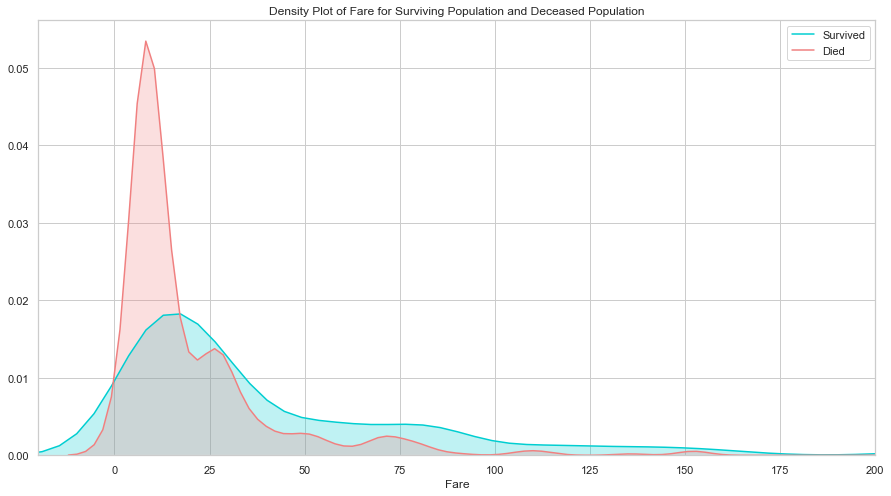

In [45]:
"""Considering FARE"""
# Now lets consider the FARE price and how it can relate to the number of survivors.

plt.figure(figsize=(15,8))
kdeAge = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
kdeAge.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

This shows that passengers that had a lower fair were significantly more likely to die.  This can also possibly be related to class (i.e. First, Second, Third) as well. Therefore I will consider "Class" next.

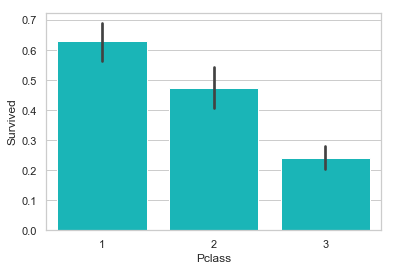

In [46]:
"""Passenger Class"""

sns.barplot('Pclass', 'Survived', data=train_df, color="darkturquoise")
plt.show()


As shown a greater number of first class passengers survived.  The higher class of the passenger the more likely they were to survive. This suggests that Cabins for First Class Passengers were closer to the deck of the ship making it easier for them to escape.

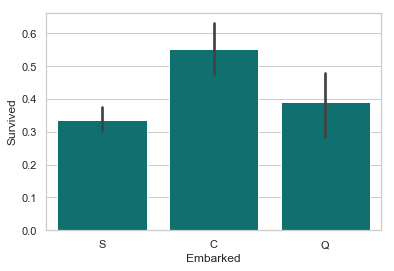

In [47]:
"""Passenger Embark Port"""
# We will now create a bar chart for the class of the passengers.
sns.barplot('Embarked', 'Survived', data=train_df, color="teal")
plt.show()


Passengers who boarded in Cherbourg, France, appear to have the highest survival rate. 
Passengers who boarded in Southampton were marginally less likely to survive than those who boarded in Queenstown. 
This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck). 
It's also worth noting the size of the whiskers in these plots. 
Because the number of passengers who boarded at Southampton was highest, the confidence around the survival rate is the highest. 
The whisker of the Queenstown plot includes the Southampton average, as well as the lower bound of its whisker. 
It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southampton counterparts.


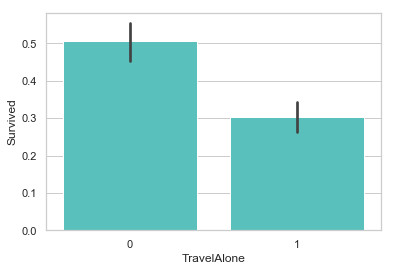

In [48]:
"""Traveling alone or with family"""

sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

Individuals traveling alone without family were more likely to die. Considering the time period those traveling alone are most likely Male.

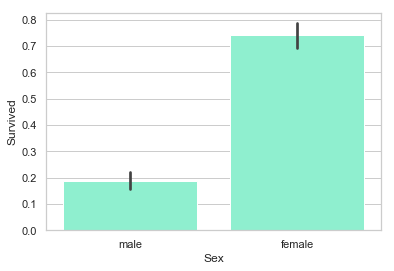

In [49]:
"""Gender"""

sns.barplot('Sex', 'Survived', data=train_df, color="aquamarine")
plt.show()

A much greater number of females survived than males

In [51]:
"""Logistical Regression"""
# Feature selection

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Selected 8 of the 9 features

In [54]:
# Recursive feature selection with cross validation

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [55]:
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

Optimal number of features: 8
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


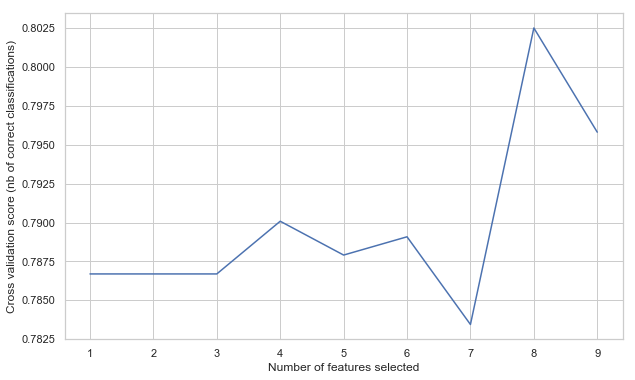

In [56]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

We are keeping 8 features

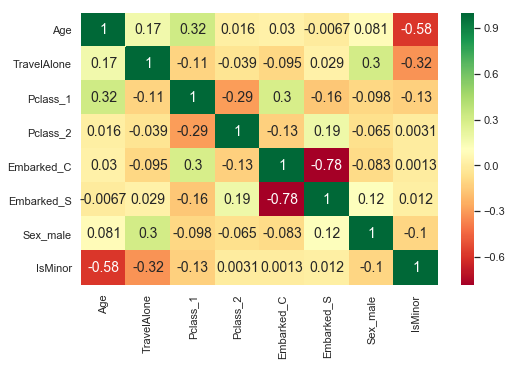

In [57]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [ ]:
"""Evaluating the model.  Model evaluation based on simple train/test split using train_test_split() function"""

# create X (features) and y (response)

X = final_train[Selected_features]
y = final_train['Survived']

use train/test split with different random_state values
we can change the random_state values that changes the accuracy scores
the scores change a lot, this is why testing scores is a high-variance estimate

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

check classification scores of logistic regression

In [59]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.839


C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


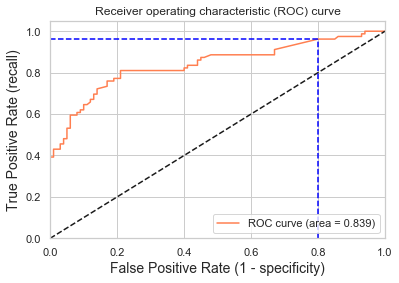

In [60]:
idx = np.min(np.where(tpr > 0.95)) 
# index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [61]:
print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Using a threshold of 0.071 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [ ]:
"""Model evaluation based on K-fold cross-validation using cross_val_score() function"""

# 10-fold cross-validation logistic regression

logreg = LogisticRegression()

Use cross_val_score function
We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
cv=10 for 10 folds
scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - although they are many

In [63]:
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')



C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [64]:
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.802
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


In [66]:
"""Model evaluation based on K-fold cross-validation using cross_validate() function with same parameters as previous K-fold validation function"""


scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [68]:
print('K-fold cross-validation results:')

for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.802 (+/-0.025)
LogisticRegression average log_loss: 0.454 (+/-0.034)
LogisticRegression average auc: 0.850 (+/-0.025)


"Fare" was left out as a feature previously, lets see what happens when it is considered.

In [69]:
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"]
X = final_train[cols]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, final_train[cols], y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [70]:
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))


K-fold cross-validation results:
LogisticRegression average accuracy: 0.796 (+/-0.028)
LogisticRegression average log_loss: 0.455 (+/-0.034)
LogisticRegression average auc: 0.849 (+/-0.025)


Observe that the model is slightly deteriorated. 
The "Fare" variable does not carry any useful information. 
Its presence is just noise for the logistic regression model.


In [71]:
"""GridSearchCV evaluating using multiple scorers simultaneously"""


X = final_train[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_


C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [72]:

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=2.8000100000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 2.8000100000000003}
best score: 0.8069584736251403


C:\Users\Brendan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Brendan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


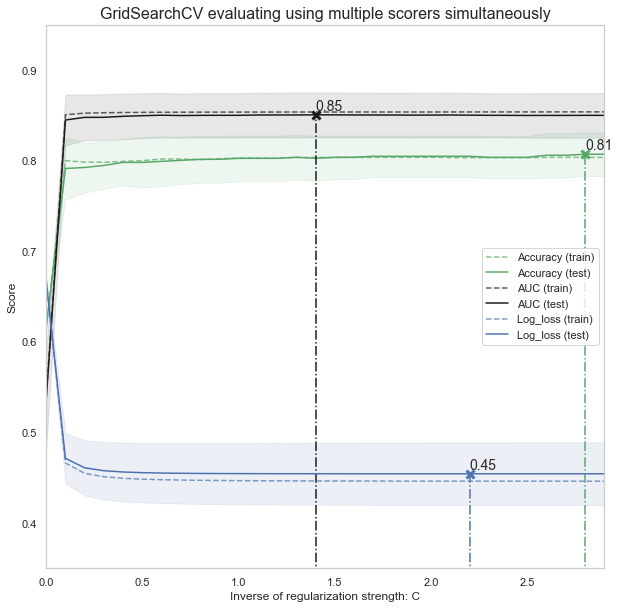

In [76]:
plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)
# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()


In [77]:
"""GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline for preprocessing simultaneously"""


#Define simple model

C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#Simple pre-processing estimators

std_scale = StandardScaler(with_mean=False, with_std=False)

# Defining the CV method: Using the Repeated Stratified K Fold

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

# Creating simple pipeline and defining the gridsearch

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, flo

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, 

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
print('='*20)
print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*20)

best params: Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clf', LogisticRegression(C=5.00001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
best params: {'clf__C': 5.00001}
best score: 0.7966329966329966


C:\Users\Brendan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Brendan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


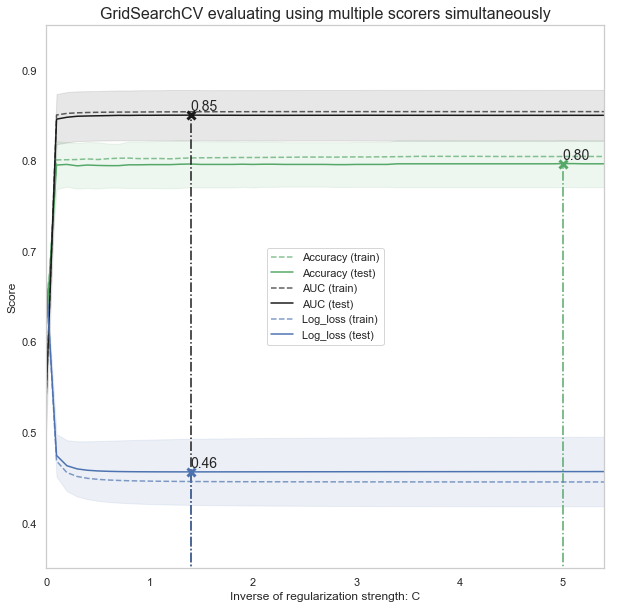

In [79]:
plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, C.max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_clf__C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()


In [80]:


"""The last step: Using the trained model to predict who in the test data set will survive the sinking of the Titanic """

final_test['Survived'] = log_clf.predict(final_test[Selected_features])
final_test['PassengerId'] = test_df['PassengerId']

result = final_test[['PassengerId','Survived']]

result.to_csv("result.csv", index=False)

result.tail()

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
